# Metropolis-Hastings

## Integral of $\exp(-|x^3|)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

seed = 239
rng = np.random.default_rng(seed)

Acceptance fraction = 0.3596


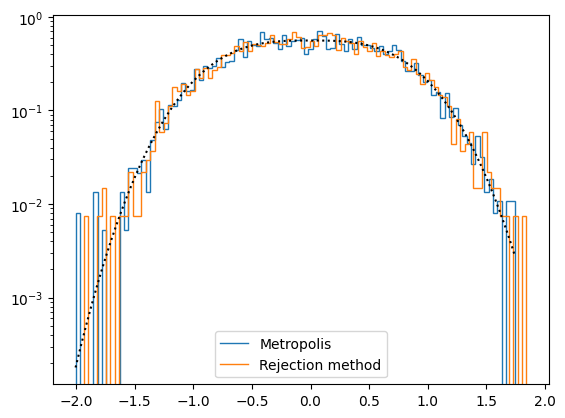

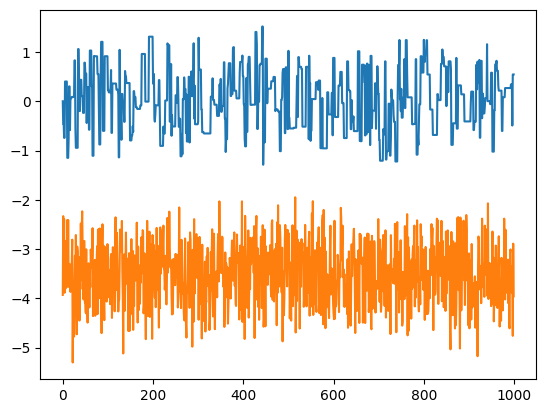

<Figure size 640x480 with 0 Axes>

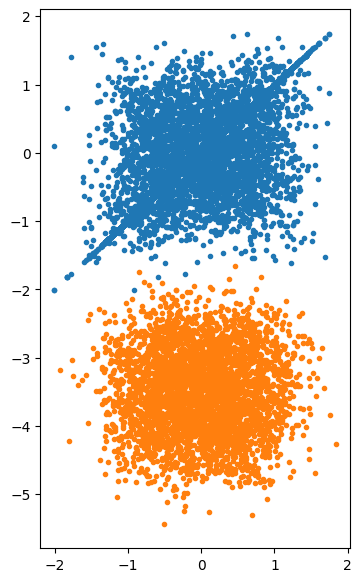

In [2]:
def f(x):
    return np.exp(-np.abs(x**3))

N = 10**4 # generate N samples

x = np.zeros(N)
x[0] = 0  # starting point

count = 0

for i in range(N-1):
    
    # Proposal
    x_try = x[i] + rng.normal(scale = 2)   

    # Accept the move or stay where we are
    u = rng.uniform()
    if u <= f(x_try) / f(x[i]):
        x[i+1] = x_try
        count = count + 1
    else:
        x[i+1] = x[i]

print("Acceptance fraction = %g" % (count/N,))

# Generate the same number of samples using the rejection method with uniform sampling
xmax = 4
xu = -xmax + 2*xmax*rng.uniform(size = 10*N)    # Generate x values between +-xmax
y = rng.uniform(size = 10*N)
xu = xu[np.where(y <= f(xu))]  
xu = xu[:count]
        
# Plot the distribution        
counts, bins = np.histogram(x, bins=100, density = True)
plt.stairs(counts, bins, label = 'Metropolis')    

counts, bins = np.histogram(xu, bins=100, density = True)
plt.stairs(counts, bins, label = 'Rejection method')    

norm,_ = scipy.integrate.quad(f,-np.inf,np.inf)
xx = np.linspace(min(x),max(x),1000)
plt.plot(xx, f(xx)/norm, 'k:')

plt.yscale('log')

plt.legend()
plt.show()

# Plot the first 1000 samples to see the time series
plt.clf()
t = np.arange(N)
plt.plot(t[:1000], x[:1000])
plt.plot(t[:1000], xu[:1000] - 3.5)
plt.show()

# Plot the point-to-point correlation
plt.clf()
plt.figure(figsize=(4,7))
plt.plot(x[:-1], x[1:], '.')
plt.plot(xu[:-1], xu[1:] - 3.5, '.')
plt.show()


Notes:

- We started at $x=0$ which is right in the middle of the high probability region. If instead you start at a point that has a low probability (e.g. try $x=-5$ as initial condition in line 7), you will see that the chain has a "burn in" period in which it moves towards the higher probability regions. The part of the chain should be discarded. 
- The time series for the MCMC shows clear correlations, whereas the rejection method samples are uncorrelated. This can be seen in the plot of $x_i$ vs $x_{i+1}$ -- in particular you can see the line of points where the proposed jump was not accepted.
- Try changing the `scale` in the normal distribution we're using for the jump and see how the acceptance ratio and the correlations behave. You want to choose a jump size that is large enough to explore the probability distribution, but small enough to get a reasonable acceptance rate for the jumps. An acceptance rate of around $0.2$-$0.3$ is good to aim for.